# Lectura y balanceo de datos

## Lectura

In [1]:
#Lo primero de todo es eliminar las imagenes corrompidas
import os
import tensorflow as tf

#Valor para contar las imágenes borradas
imagenesBorradas = 0

#Bucle para leer las imagenes de las carpetas
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages/test", folder_name)
    for fname in os.listdir(folder_path):
        #Obtenemos el camino de cada imagen
        fpath = os.path.join(folder_path, fname)
        #Y vemos si en la cabecera los bytes tienen codificado el string JFIF
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        #Si no contiene el string
        if not is_jfif:
            imagenesBorradas += 1 #Contamos una imagen que borramos
            # Y borramos la imagen
            os.remove(fpath)

#Finalmente mostramos cuantas imágenes hemos borrado
print("Imagenes %d borradas" % imagenesBorradas)

Imagenes 0 borradas


In [2]:
#Paquetes
import tensorflow as tf
import numpy as np

#Extracción de datos
lote = 32 #Numero de muestras con el que se trabaja hasta que se actualizan los parametros
data_training = tf.keras.preprocessing.image_dataset_from_directory( #Se necesita TensorFlow version 2.3.0 o superior
    "PetImages/train", #Ruta de los datos
    label_mode = 'int', #Las imágenes se etiquetan como enteros
    color_mode = 'rgb', #Las imágenes son en color
    batch_size=lote, #Tamaño del lote
    validation_split=0.2, #Proporcion de muestras de validacion
    image_size=(180, 180), #Tamaño en píxeles de la imagen
    subset="training", #Tipo de subset
    seed=1337, #Semilla desde la que empiezo a coger muestras
)

data_validation = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages/train",
    label_mode = 'int', 
    color_mode = 'rgb',
    batch_size=lote, 
    validation_split=0.2, 
    image_size=(180, 180),
    subset="validation",
    seed=1337,
)

data_test = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages/test",
    label_mode = 'int', 
    color_mode = 'rgb',
    batch_size=lote, 
    image_size=(180, 180),
)

#Número de lotes
print(
    "Número de lotes de entrenamiento: %d"
    % tf.data.experimental.cardinality(data_training)
)
print(
    "Número de lotes de validación: %d" % tf.data.experimental.cardinality(data_validation)
)
print(
    "Número de lotes de test: %d" % tf.data.experimental.cardinality(data_test))

Found 21533 files belonging to 2 classes.
Using 17227 files for training.
Found 21533 files belonging to 2 classes.
Using 4306 files for validation.
Found 1877 files belonging to 2 classes.
Número de lotes de entrenamiento: 539
Número de lotes de validación: 135
Número de lotes de test: 59


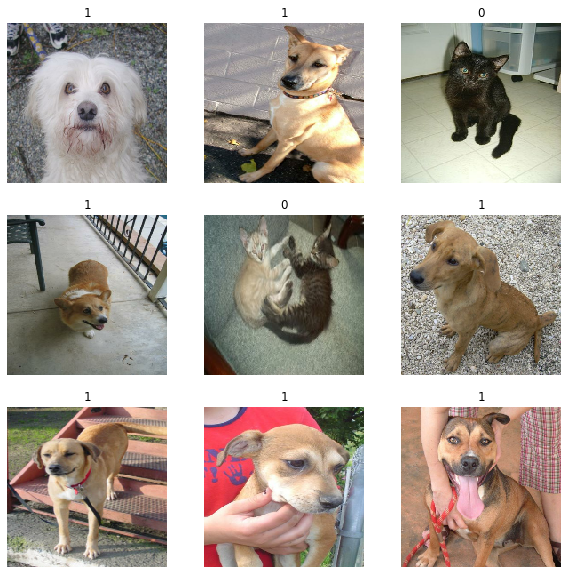

In [3]:
#Importamos el paquete para graficar
import matplotlib.pyplot as plt

#Generamos una figura de 10x10
plt.figure(figsize=(10, 10))

for imagen, etiqueta in data_training.take(1):
    #Pintaremos las 9 primeras imágenes
    for i in range(9):
        #Usamos subplot para pintar
        ax = plt.subplot(3, 3, i + 1) #3 filas, 3 columnas y la posicion especificada por i
        plt.imshow(imagen[i].numpy().astype("uint8")) #Mostramos la imagen
        plt.title(int(etiqueta[i])) #Y su titulo es la etiqueta asignada
        plt.axis("off") #Borramos los ejes para mejorar la visualizacion 

# Preparación de las imágenes

In [4]:
#Aumento de datos usando rotaciones 

#Importamos los paquetes necesarios
from tensorflow import keras
from tensorflow.keras import layers

#Usamos una red neuronal de preprocesado para ello
aumentoDatos = keras.Sequential( #Para elaborar una red neuronal por capas llamamos al método sequential
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"), #Capa que ejecuta un giro aleatorio sobre el eje horizontal
        layers.experimental.preprocessing.RandomRotation(0.1), #Giro aleatorio de valor [-2pi*0,1 , 2pi*0,1]
    ]
)

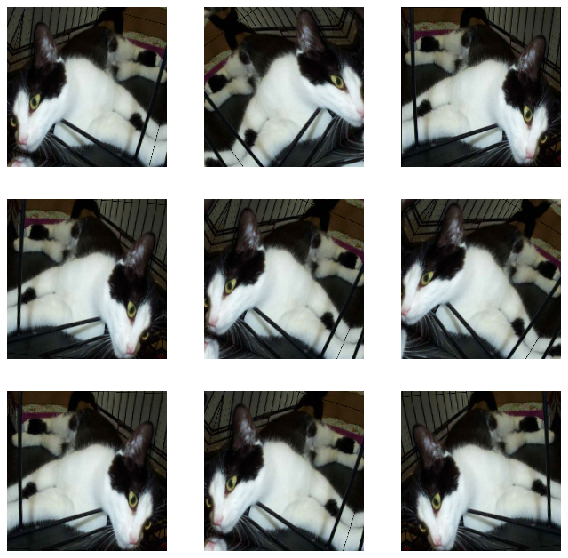

In [5]:
plt.figure(figsize=(10, 10))
for imagen, _ in data_training.take(1): #Cogemos la primera imagen
    for i in range(9):
        nuevaImagen = aumentoDatos(imagen) #Generamos una nueva imagen
         #Y la pintamos como antes
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(nuevaImagen[0].numpy().astype("uint8"))
        plt.axis("off")

# Modelo predictivo

In [7]:
entrenamiento = data_training.map(
  lambda x, y: (aumentoDatos(x, training=True), y))
validacion = data_validation.map(
  lambda x, y: (aumentoDatos(x, training=True), y))
test = data_test.map(
  lambda x, y: (aumentoDatos(x, training=True), y))

#Y hacemos un prefetching como en el modelo de texto
entrenamiento = entrenamiento.prefetch(buffer_size=32)
validacion = validacion.prefetch(buffer_size=32)
test = test.prefetch(buffer_size=32)

In [8]:
#Métricas de evaluación
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
#Importamos el paquete de las capas neuronales
from tensorflow.keras import layers

#Primero definimos las formas de entrada
entradas = keras.Input(shape=(180,180) + (3,))

#Normalizamos los pixeles de las imagenes
x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(entradas)

#Realizamos la convolución en 2D: 32 de longitud, tamaño del kernel de 3 y saltos de dos. 
#En este caso si que usamos padding, para que todos los arrays de caracteristicas tengan el mismo tamaño
x = layers.Conv2D(32, 3, strides=2, padding="same")(x)

#Normaliamos de nuevo el resultado
x = layers.BatchNormalization()(x)

#Y aplicamos la funcion de activacion a las salidas. 
x = layers.Activation("relu")(x)

#Repetimos los 3 pasos anteriores (Se hacen 2 convoluciones)
x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

activacionPasada = x  # Vamos a incluir la activacion de los bloques pasados a la red neuronal para que pueda aprender mejor

for size in [128, 256, 512, 728]: #Vamos incrementando el tamaño de las convoluciones
     
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x) #Aplica 2 convoluciones 1D en lugar de una unica convolucion 2D
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # incluimos la activacion pasada tras las 2 convoluciones
    activacion = layers.Conv2D(size, 1, strides=2, padding="same")(
        activacionPasada
    )
    x = layers.add([x, activacion])  # la añadimos a la capa neuronal
    activacionPasada = x  # Y actualizamos la activacion

#Realizamos la ultima convolucion de 1024
x = layers.SeparableConv2D(1024, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

#Agrupamos los datos usando la media global
x = layers.GlobalAveragePooling2D()(x)

#Y evitamos el sobreentrenamiento
x = layers.Dropout(0.5)(x)
salidas = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(entradas , salidas)

#keras.utils.plot_model(model, show_shapes=True)
#Resumen del modelo elaborado
model.summary()

# Compilamos la red, siendo la funcion de coste la entropia binaria cruzada, el optimizador adam y las metricas explicadas
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(1e-3), metrics=['accuracy',f1_m,precision_m, recall_m])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 32)   896         rescaling[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 90, 90, 32)   128         conv2d[0][0]                     
_______________________________________________________________________________________

In [10]:
#Especifico cada cuantos grupos actualizo los parametros de la red
iteraciones = 5

# Ajustamos el modelo a los conjuntos de entrenamiento y validacion
historia = model.fit(entrenamiento, validation_data=validacion, epochs=iteraciones)

Epoch 1/5
539/539 [==============================] - 3294s 6s/step - loss: 0.6338 - accuracy: 0.6595 - f1_m: 0.6403 - precision_m: 0.6729 - recall_m: 0.6368 - val_loss: 1.2513 - val_accuracy: 0.5072 - val_f1_m: 0.0467 - val_precision_m: 0.3370 - val_recall_m: 0.0255
Epoch 2/5
539/539 [==============================] - 3198s 6s/step - loss: 0.4880 - accuracy: 0.7692 - f1_m: 0.7590 - precision_m: 0.7863 - recall_m: 0.7513 - val_loss: 0.4511 - val_accuracy: 0.7901 - val_f1_m: 0.7596 - val_precision_m: 0.8781 - val_recall_m: 0.6811
Epoch 3/5
539/539 [==============================] - 3097s 6s/step - loss: 0.3972 - accuracy: 0.8217 - f1_m: 0.8140 - precision_m: 0.8379 - recall_m: 0.8073 - val_loss: 0.4827 - val_accuracy: 0.7856 - val_f1_m: 0.7367 - val_precision_m: 0.9405 - val_recall_m: 0.6143
Epoch 4/5
539/539 [==============================] - 3357s 6s/step - loss: 0.3343 - accuracy: 0.8547 - f1_m: 0.8498 - precision_m: 0.8685 - recall_m: 0.8458 - val_loss: 0.3083 - val_accuracy: 0.8609 

In [11]:
model.evaluate(test)

59/59 [==============================] - 81s 1s/step - loss: 0.3911 - accuracy: 0.8391 - f1_m: 0.8435 - precision_m: 0.8040 - recall_m: 0.8955


[0.39112621545791626,
 0.839104950428009,
 0.8435354828834534,
 0.8040063977241516,
 0.8955202102661133]

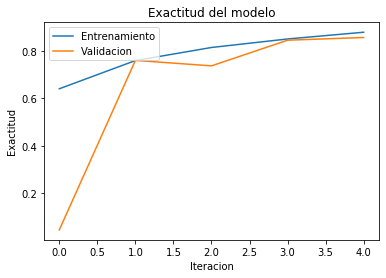

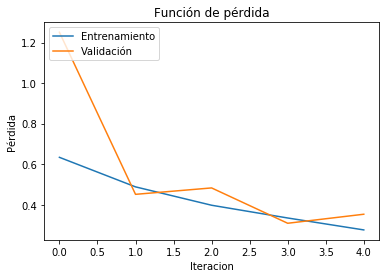

In [14]:
#Importamos la libreria para pintar 
import matplotlib.pyplot as plt

# Ploteamos como es nuestra exactitud
plt.plot(historia.history['f1_m'])
plt.plot(historia.history['val_f1_m'])
plt.title('Exactitud del modelo')
plt.ylabel('F1')
plt.xlabel('Iteracion')
plt.legend(['Entrenamiento', 'Validacion'], loc='upper left')
plt.show()

# Ploteamos como se minimiza la perdida de nuestro modelo
plt.plot(historia.history['loss'])
plt.plot(historia.history['val_loss'])
plt.title('Función de pérdida')
plt.ylabel('Pérdida')
plt.xlabel('Iteracion')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()